In [2]:
%%time
import argparse
import numpy as np
import sys, os
import math
import logging
import time
import galsim
import galsim.roman as roman
import datetime
import pickle

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from astropy.io import fits
from matplotlib.ticker import SymmetricalLogLocator
import h5py 
import pandas as pd
import gzip

CPU times: user 1.02 s, sys: 730 ms, total: 1.75 s
Wall time: 25.5 s


In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext']=True

In [3]:
def effective_wavelength(bandpass, order = 2, norm = False, cent = 1):
    wave_arr = np.linspace(bandpass.blue_limit, bandpass.red_limit, 1000)
    transmission = bandpass(wave_arr)
    numerator = np.trapz((wave_arr - cent*bandpass.effective_wavelength)**order * transmission, wave_arr)
    denominator = np.trapz(transmission, wave_arr)
    lambda_eff = numerator
    if norm:
        lambda_eff = numerator / denominator
    return lambda_eff

In [4]:
def anal_slope(mags_ref, mags_filt_ = None, filt_ = 'J129', ref = 'H158', midpoint = None,
              filters_filt_ = None, filters_ref = None):
    if mags_filt_ is None:
        mags_filt_ = mags_ref
        
    if filters_filt_ is None:
        filters_filt_ = roman_filters
    if filters_ref is None:
        filters_ref = roman_filters
        

    f_H = get_raw_flux(mags_ref, ref)
    f_F = get_raw_flux(mags_ref, filt_)
    eff_filt_ = filters_filt_[filt_].effective_wavelength
    eff_h = filters_ref[ref].effective_wavelength
    norm_h = effective_wavelength(filters_ref[ref], order = 0, norm = False, cent = 0)
    if midpoint is None:
        norm = f_H*norm_h
    else:
        bp = roman_filters[midpoint]
        zp = bp.zeropoint
        norm = 10**(-(mags[midpoint] - zp)/2.5)
    col = (f_H-f_F)/norm
    an_slope = 1/(eff_h - eff_filt_)
    return an_slope*col

def get_raw_flux(mags, filt):
    bp = roman_filters[filt]
    zp = bp.zeropoint
    flux = 10**(-(mags[filt] - zp)/2.5)
    flux /= effective_wavelength(roman_filters[filt], order = 0, norm = False, cent = 0)
    return flux

In [5]:
use_filters = 'YJHFKW'
roman_filters = roman.getBandpasses(AB_zeropoint=True)

# Get the names of the ones we will use here.
filters = [filter_name for filter_name in roman_filters if filter_name[0] in use_filters]

filters_copy = filters.copy()
filters_copy[4] = filters_copy[5]
filters_copy[5] = filters[4]
filters = filters_copy

blue_limit, red_limit, eff_wave = np.zeros(6), np.zeros(6), np.zeros(6)
for i in range(0,len(filters)):

    bandpass = roman_filters[filters[i]]
    eff_wave[i] = bandpass.effective_wavelength
    blue_limit[i], red_limit[i] = bandpass.blue_limit, bandpass.red_limit
    sampling_rate = (eff_wave[i]/1e3)*7.9/10
    print(filters[i] + ': %.2f'%sampling_rate )

Y106: 0.84
J129: 1.02
H158: 1.25
F184: 1.46
K213: 1.68
W146: 1.16


In [6]:
roman_stars_flux = {}
for filter_name in filters:
    pickle_out = open("Star_Fluxes/Stars_Flux_10000Gal_" + filter_name ,"rb")
    roman_stars_flux[filter_name] = pickle.load(pickle_out)
    pickle_out.close()

## Analytical Estimator

In [7]:
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_diffsky_10307", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff = {}
coeff_gal = {}
coeff_star = {}
flux_star = {}
flux_gal = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal[filter_] = coeffs['gal'][1][filter_]
    coeff_star[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]

In [8]:
use_filters = ['Y106', 'J129', 'H158', 'F184', 'W146']
pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_cosmoDC2_10067", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff_cd2 = {}
coeff_gal_cd2 = {}
coeff_star_cd2 = {}
flux_star = {}
flux_gal = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff_cd2[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal_cd2[filter_] = coeffs['gal'][1][filter_]
    coeff_star_cd2[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]

In [9]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_mags = roman_mag_info['obs_mag']['A']
true_mags = roman_mag_info['true_mag']['A']
z = roman_mag_info['z']

pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_cosmodc2_10067_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_mags_cd2 = roman_mag_info['obs_mag']['A']
z_cd2 = roman_mag_info['z']



pickle_out = open("Gal_props_catnoise/roman_star_obsmags_diffsky","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
obs_star_mags = roman_mag_info['obs_mag']['A']
true_star_mags = roman_mag_info['true_mag']['A']
snr_stars = roman_mag_info['snr']['A']

In [10]:
use_filters = np.array(['Y106', 'J129', 'H158', 'F184'])

def get_anal_slopes(obs_mags, ref, use_filters):
    slope_dict = {}
    filts = use_filters[use_filters != ref]
    for filt_ in filts:
        slope_dict[filt_] = anal_slope(obs_mags, filt_ = filt_, ref = ref)
    return slope_dict
def get_all_slopes(obs_mags, use_filters):
    slope_dict = {}
    for ref in use_filters:
        slope_dict[ref] = get_anal_slopes(obs_mags, ref, use_filters)
    return slope_dict
def get_star_slopes(an_slope, obs_star_mags, ref, use_filters, num_ = 10000):
    y_star_anal = {}
    zp = roman_filters[ref].zeropoint
    star_fluxes = 10**(-(obs_star_mags[ref] - zp)/2.5)
    filts = use_filters[use_filters != ref]
    for filt_ in filts:
        y_star_filt = []
        for i in range(num_):
            star_slopes = an_slope[filt_][i*40:(i+1)*40]
            star_f = star_fluxes[i*40:(i+1)*40]
            star_cut = np.logical_and(snr_stars[ref][i*40:(i+1)*40] > 100, true_star_mags[ref][i*40:(i+1)*40] > 17.9)
            pred = np.sum(star_slopes[star_cut]*star_f[star_cut])/np.sum(star_f[star_cut])
            y_star_filt.append(pred)
        y_star_anal[filt_] = np.array(y_star_filt)
    return y_star_anal
def get_all_star_slopes(an_slope, obs_mags, use_filters):
    slope_dict = {}
    for ref in use_filters:
        slope_dict[ref] = get_star_slopes(an_slope[ref],obs_mags, ref, use_filters)
    return slope_dict

In [807]:
an_slope_diffsky = get_all_slopes(obs_mags,  use_filters)
an_slope_cd2 = get_all_slopes(obs_mags_cd2,  use_filters)
an_slope_allstar = get_all_slopes(obs_star_mags, use_filters)

In [808]:
an_slope_star = get_all_star_slopes(an_slope_allstar, obs_star_mags, use_filters)

In [809]:
# using analytical on stars too

#an_diff_Y = an_slope_star['H158']['Y106'] - an_slope_diffsky['H158']['Y106']
#an_diff_J = an_slope_star['H158']['J129'] - an_slope_diffsky['H158']['J129']
#an_diff_F = an_slope_star['H158']['F184'] - an_slope_diffsky['H158']['F184']
#an_diff_JF = (an_diff_J + an_diff_F)/2

#an_diff_cd2_J = an_slope_star['H158']['J129'] - an_slope_cd2['H158']['J129']
#an_diff_cd2_F = an_slope_star['H158']['F184'] - an_slope_cd2['H158']['F184']
#an_diff_cd2_JF = (an_diff_cd2_J + an_diff_cd2_F)/2

In [810]:
# using perfect coeff for stars
an_diff_Y = coeff_star['H158'] - an_slope_diffsky['H158']['Y106']
an_diff_J = coeff_star['H158'] - an_slope_diffsky['H158']['J129']
an_diff_F = coeff_star['H158'] - an_slope_diffsky['H158']['F184']
an_diff_JF = (an_diff_J + an_diff_F)/2

an_diff_cd2_J = coeff_star_cd2['H158'] - an_slope_cd2['H158']['J129']
an_diff_cd2_F = coeff_star_cd2['H158'] - an_slope_cd2['H158']['F184']
an_diff_cd2_JF = (an_diff_cd2_J + an_diff_cd2_F)/2

In [816]:
pickle_out = open("SED_fit_coeff/final_run/10000Gal_pred_A_H_diffsky_10307" ,"wb")
pickle.dump({'J': an_diff_J, 'F': an_diff_F, 'JF':an_diff_JF}, pickle_out)
pickle_out.close()

pickle_out = open("SED_fit_coeff/final_run/10000Gal_pred_A_H_cosmoDC2_10067" ,"wb")
pickle.dump({'J': an_diff_cd2_J, 'F': an_diff_cd2_F, 'JF':an_diff_cd2_JF}, pickle_out)
pickle_out.close()

### Understanding results

In [11]:
def get_galSED(file_name):
    with gzip.open(file_name, 'rb') as f:
        file_content = f.read()
    # Split the content by lines
    lines = file_content.splitlines()

    # Extract the data lines (skip the first line which is the header)
    data_lines = lines[1:]

    # Create a pandas DataFrame from the data lines
    # Use a space as the delimiter (split each line into two columns)
    data = [line.split() for line in data_lines]

    # Create a DataFrame and define column names
    df = pd.DataFrame(data, columns=['Wavelength (nm)', 'F_lamA (normalized erg/cm2/s/A)'])
    wave = pd.to_numeric(df['Wavelength (nm)'])
    f_sed = pd.to_numeric(df['F_lamA (normalized erg/cm2/s/A)'])
    return np.array(wave), np.array(f_sed)

In [12]:
def get_gal_obj_cd2 (i, filter_name ):
    bp500 = galsim.Bandpass(galsim.LookupTable([499, 500, 501], [0, 1, 0]),
                                             wave_type='nm').withZeropoint('AB')
    gal_id = str(np.array(gal_data['id'])[i])
    bandpass = roman_filters[filter_name]
    redshift = np.array(gal_data['redshift'])[i]
    f_sed_disk_name = sed_dict['disk_sed'][gal_id].copy()
    f_sed_bulge_name = sed_dict['bulge_sed'][gal_id].copy()
    f_disk_magnorm = sed_dict['disk_magnorm'][gal_id].copy()
    f_bulge_magnorm = sed_dict['bulge_magnorm'][gal_id].copy()
    
    f_sed_disk = sed_f_dict[f_sed_disk_name]
    f_sed_bulge = sed_f_dict[f_sed_bulge_name]
    
    disk_lk = galsim.LookupTable( x = waves, f = f_sed_disk)
    bulge_lk = galsim.LookupTable( x = waves, f = f_sed_bulge)
    disk_sed =  galsim.SED(disk_lk, 'nm', 'flambda', redshift = redshift).withMagnitude(f_disk_magnorm,bp500 )
    bulge_sed =  galsim.SED(bulge_lk, 'nm', 'flambda', redshift = redshift).withMagnitude(f_bulge_magnorm,bp500 )
    
    f_sed = disk_sed._orig_spec.f + bulge_sed._orig_spec.f 
    tot_sed =  f_sed
    tot_lookup = galsim.LookupTable(x = waves, f = tot_sed)
    tot_sed = galsim.SED(tot_lookup, wave_type = 'nm', flux_type='flambda', redshift = redshift)
    tot_sed = tot_sed.withFlux(np.array(flux_data['roman_flux_' + filter_name])[i], bandpass)
    return np.array(flux_data['roman_flux_' + filter_name])[i], tot_sed

In [13]:
def get_gal_obj (i, filter_name ):
    flux_fact = (galsim.SED._h * galsim.SED._c)
    gal_id = str(np.array(gal_data['galaxy_id'])[i])
    bandpass = roman_filters[filter_name]
    redshift = np.array(gal_data['redshift'])[i]
    bulge_hlr = np.array(gal_data['spheroidHalfLightRadiusArcsec'])[i]
    disk_hlr = np.array(gal_data['diskHalfLightRadiusArcsec'])[i]
    disk_shear1, disk_shear2 = np.array(gal_data['diskEllipticity1'])[i], np.array(gal_data['diskEllipticity2'])[i]
    bulge_shear1, bulge_shear2 = np.array(gal_data['spheroidEllipticity1'])[i], np.array(gal_data['spheroidEllipticity2'])[i]
    f_sed = data[gal_id[:9]][gal_id][()].copy()
    bulge_lookup = galsim.LookupTable( x = wave_list/10, f = f_sed[0])
    disk_lookup = galsim.LookupTable( x = wave_list/10, f = f_sed[1])
    knots_lookup = galsim.LookupTable( x = wave_list/10, f = f_sed[2])
    bulge_sed = galsim.SED(bulge_lookup, wave_type = 'nm', flux_type='fnu', redshift = redshift)
    disk_sed = galsim.SED(disk_lookup, wave_type = 'nm', flux_type='fnu', redshift = redshift)
    knots_sed = galsim.SED(knots_lookup, wave_type = 'nm', flux_type='fnu', redshift = redshift)
    bulge = galsim.Sersic(4, half_light_radius=bulge_hlr).shear(g1 =bulge_shear1 , g2 = bulge_shear2)
    disk = galsim.Sersic(1, half_light_radius=disk_hlr).shear(g1 =disk_shear1 , g2 = disk_shear2)
    obj = bulge*bulge_sed + disk*(disk_sed + knots_sed)
    obj = obj.withFlux(np.array(flux_data['roman_flux_' + filter_name])[i], bandpass)
    tot_sed =  f_sed[0] + f_sed[1] + f_sed[2] 
    tot_lookup = galsim.LookupTable( x = wave_list/10, f = tot_sed)
    tot_sed = galsim.SED(tot_lookup, wave_type = 'nm', flux_type='fnu', redshift = redshift)
    tot_sed = tot_sed.withFlux(np.array(flux_data['roman_flux_' + filter_name])[i], bandpass)
    return np.array(flux_data['roman_flux_' + filter_name])[i], tot_sed
    #return f_sed[0] + f_sed[1] + f_sed[2] , redshift

In [40]:
def get_star_obj(l, filter_name , num_stars = 40):
    bp500 = galsim.Bandpass(galsim.LookupTable([499, 500, 501], [0, 1, 0]),
                                             wave_type='nm').withZeropoint('AB')
    bandpass = roman_filters[filter_name]
    mag_min, mag_max = get_mag_range(filter_name)
    star_obj = star_data#[l*num_stars:(l+1)*num_stars]
    star_seds = []
    #star_flux= star_flux_data[l*num_stars:(l+1)*num_stars]
    star_sed_file = stellar_root + np.array(star_obj['sed_filepath'])[l]
    star_sed = pd.read_csv(star_sed_file, compression='gzip', header=1, sep=' ', quotechar='"')
    wavelength = np.array(star_sed)[:,0]
    SED = np.array(star_sed)[:,1]
    lookup_table = galsim.LookupTable(wavelength, SED)
    sed =  galsim.SED(lookup_table, 'nm', 'flambda')#.withFluxDensity(target_flux_density=1.0, wavelength=500))

    magnorm = np.array(star_obj['magnorm'])[l]
    #MW_av = star_obj[j: j+1]['MW_av']
    #MW_rv = star_obj[j: j+1]star_data['MW_rv']
    flux_500 = np.exp(-0.9210340371976184 * magnorm)
    sed = sed.withMagnitude(0, bp500)
    sed = sed*flux_500
    star_mag = sed.calculateMagnitude(bandpass)
    #SED = ((wavelength)*5e-9 + 1e-3)/(wavelength)*(galsim.SED._h* galsim.SED._c)
    #lookup_table = galsim.LookupTable(wavelength, SED)
    #sed =  galsim.SED(lookup_table, 'nm', 'flambda')
    if star_snr[filter_name][l] > 100 and star_mag > mag_min:
        #star_seds.append(sed)
    # The rng for photon shooting should be different for each filter.
        native_wave = sed._orig_spec.x
        native_f = sed._orig_spec.f
        return native_wave, native_f
    return None, None

def get_mag_range(filter_name):
    if filter_name == 'Z087':
         return 17.85, 21.37
    if filter_name == 'Y106':
         return 17.9, 21.2
    if filter_name == 'J129':
        return 17.9, 21.2
    if filter_name == 'H158':
        return 17.9, 21.2
    if filter_name == 'F184':
        return 17.2, 20.8
    if filter_name == 'K213':
        return 17.0, 20.6
    if filter_name == 'W146':
        return 19.1, 22.4

In [5]:
is_cosmoDC2 = False
scenario = 'A'
cat_file = 'roman_gal_obsmags_diffsky_10307_10000cut'
#cat_file = 'roman_gal_obsmags_cosmodc2_10067_10000cut'
pickle_out = open("Gal_props_catnoise/" + cat_file,"rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()

gal_ids = roman_mag_info['gal_id']
#z = roman_mag_info['z']
obs_mags =  roman_mag_info['obs_mag'][scenario]
mag_cut,rand_idx = roman_mag_info['cut'], roman_mag_info['rand_ind']

pickle_out = open("Gal_props_catnoise/roman_star_obsmags_diffsky","rb")
roman_star_mag_info = pickle.load(pickle_out)
pickle_out.close()
star_snr = roman_star_mag_info['snr'][scenario]


# read catalog and make cuts    
data_dir = '/hildafs/projects/phy200017p/share/euclid_sim/input_catalog/roman_rubin_cats_v1.1.2_faint/'
ext = ''
#data_dir = 'cosmoDC2/'
if is_cosmoDC2:
    ext = '_subset_fullsed'
    cat = 'cosmoDC2'
else:
    ext = ''
    cat = 'diffsky'
healpix_file = '10307'  ## 10307 for diffsky and 10067 for cosmoDC2
#healpix_file = '10067'
gal_data = pd.read_parquet(data_dir + 'galaxy_'+ healpix_file + ext +'.parquet', engine='pyarrow')
flux_data = pd.read_parquet(data_dir +'galaxy_flux_'+ healpix_file + ext + '.parquet', engine='pyarrow')

gal_data = gal_data[mag_cut].reset_index(drop=True)
flux_data = flux_data[mag_cut].reset_index(drop=True)

indx_seed = 1234
#np.random.seed(indx_seed)
#train_indices = np.random.choice(np.arange(list_len), num_g, replace = False)
gal_data = gal_data.iloc[rand_idx].reset_index(drop=True)
flux_data = flux_data.iloc[rand_idx].reset_index(drop=True)
list_len = len(flux_data)

num_train = list_len


## reading SEDs

if not is_cosmoDC2:
    filename = data_dir +"galaxy_sed_" + healpix_file + ".hdf5"
    f = h5py.File(filename, "r")
    data = f['galaxy']
    wave_list = f['meta']['wave_list'][()]
    
if is_cosmoDC2:
    filename = 'cosmoDC2/' +"sed_fit_"+ healpix_file +".h5"
    f = h5py.File(filename, "r")
    gal_id = f['galaxy_id'][()].astype(str)
    disk_sed_idx = f['disk_sed'][()]
    bulge_sed_idx = f['bulge_sed'][()]
    disk_sed_name = f['sed_names'][()][disk_sed_idx]
    bulge_sed_name = f['sed_names'][()][bulge_sed_idx]
    disk_magnorm = f['disk_magnorm'][()][3]
    bulge_magnorm = f['bulge_magnorm'][()][3]

    disk_sed_name = np.array([s.decode('utf-8') for s in disk_sed_name])
    bulge_sed_name = np.array([s.decode('utf-8') for s in bulge_sed_name])

    #disk_magnorm[disk_magnorm == np.inf] = 200
    #bulge_magnorm[bulge_magnorm == np.inf] = 200

    disk_dict = dict(zip(gal_id, disk_sed_name))
    bulge_dict = dict(zip(gal_id, bulge_sed_name))
    disk_dict_magnorm = dict(zip(gal_id, disk_magnorm))
    bulge_dict_magnorm = dict(zip(gal_id, bulge_magnorm ))
    sed_dict = {}
    sed_dict['disk_sed'] = disk_dict
    sed_dict['bulge_sed'] = bulge_dict
    sed_dict['disk_magnorm'] = disk_dict_magnorm
    sed_dict['bulge_magnorm'] = bulge_dict_magnorm

    lst_files = os.listdir('galaxySED/')
    file_names = []
    gal_SEDs = [] 
    for file_ in lst_files:
        file_name = os.path.join('galaxySED/',file_)
        file_names.append(file_name)
        wave, f_sed = get_galSED(file_name)
        if len(wave) == 6900: 
            f_sed = f_sed[1:]
            wave = wave[1:]
        gal_SEDs.append(f_sed)
    waves = wave
    sed_f_dict = dict(zip(file_names, gal_SEDs))

In [16]:
# read star catalog
lst_files = os.listdir('stellar_SED/')
lst_files = [s for s in lst_files if s[12] == '1']
lst_flux_files = []
for lst_file in lst_files:
    lst_flux_files.append(lst_file[:11] +'_flux' + lst_file[11:])
comb_star_data = pd.read_parquet('stellar_SED/' + lst_files[0], engine='pyarrow')
comb_star_flux_data = pd.read_parquet('rubin_roman_star_files/' + lst_flux_files[0], engine='pyarrow')
for file in lst_files[1:]:
    temp_star_data = pd.read_parquet('stellar_SED/' + file, engine='pyarrow')
    comb_star_data = pd.concat([comb_star_data,temp_star_data], ignore_index=True)
for file in lst_flux_files[1:]:
    temp_star_data = pd.read_parquet('rubin_roman_star_files/' + file, engine='pyarrow')
    comb_star_flux_data = pd.concat([comb_star_flux_data,temp_star_data], ignore_index=True)
    
kurucz_mask = np.zeros(len(comb_star_data), dtype = bool)
for i in range(len(comb_star_data)):
    sed_file = comb_star_data['sed_filepath']
    if sed_file[i][8] == 'k':
        kurucz_mask[i] = True
        
star_data= comb_star_data[kurucz_mask]
star_flux_data= comb_star_flux_data[kurucz_mask]
stellar_root = '/hildafs/projects/phy200017p/share/tq_share/'
stellar_dir = ['gizis_SED' , 'kurucz' , 'mlt' , 'old_mlt' , 'phoSimMLT' , 'wDs']

In [6]:
list_len

10000

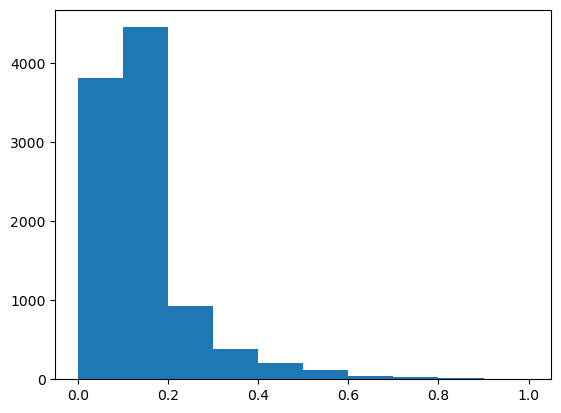

(0.14997856, 0.27298138)

In [7]:
plt.hist(np.array(gal_data['spheroidHalfLightRadiusArcsec']), range = (0,1))
plt.show()
np.mean(np.array(gal_data['spheroidHalfLightRadiusArcsec'])), np.mean(np.array(gal_data['diskHalfLightRadiusArcsec']))

In [42]:
np.min(np.array(gal_data['spheroidHalfLightRadiusArcsec'])), np.min(np.array(gal_data['diskHalfLightRadiusArcsec']))

(0.036332667, 0.07312557)

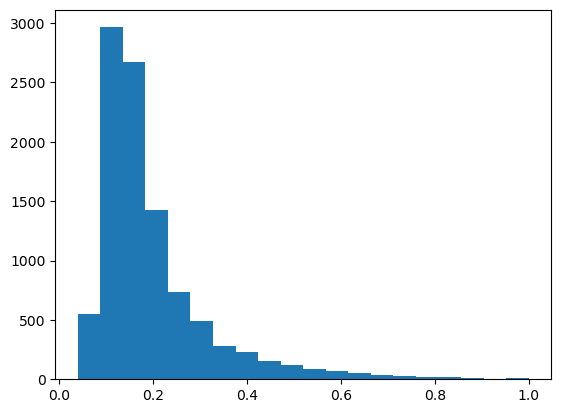

In [32]:
pickle_out = open("Gal_props_catnoise/gal_props_approx_diffsky_10307","rb")
gal_props_10307 = pickle.load(pickle_out)
pickle_out.close()
hlr = np.sqrt(gal_props_10307['H158']['a'][mag_cut][rand_idx]*gal_props_10307['H158']['b'][mag_cut][rand_idx])
plt.hist(hlr, range = (0.04, 1), bins = 20)
plt.show()

In [41]:
len(hlr[hlr < 0.08])

280

In [19]:
raw_flux = {}
raw_flux['H158'] = get_raw_flux(true_mags, 'H158')
raw_flux['J129'] = get_raw_flux(true_mags, 'J129')
raw_flux['F184'] = get_raw_flux(true_mags, 'F184')

In [120]:
#sed_f._flux_to_photons_fnu(obj_f, obj_wave)*obj_wave/sed_f.flux_factor

In [31]:
bandpass = roman_filters['H158']
#avg_sed = np.zeros((10000,2000))
#native_wave = np.linspace(800, 2100, 2000)
star_seds = []
for idx in range(400000):
    filter_name = 'H158'
    wave, f = get_star_obj(idx, filter_name, num_stars=40)
    if f is not None:
        star_seds.append(f)

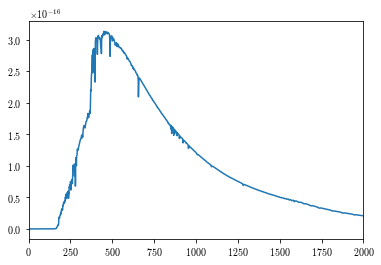

In [43]:
avg_star_seds = np.mean(star_seds, axis = 0 )
plt.plot(wave, avg_star_seds)
plt.xlim(0,2000)
plt.show()

In [44]:
np.savez("../PyIMCOM/star_avg_sed.npz", x=wave, y=avg_star_seds)

In [256]:
bandpass = roman_filters['H158']
avg_sed = np.zeros((10000,2000))
native_wave = np.linspace(800, 2100, 2000)
for idx in range(10000):
    filter_name = 'H158'
    if is_cosmoDC2:
        flux, sed_f = get_gal_obj_cd2(idx, filter_name)
    else:
        flux, sed_f = get_gal_obj(idx, filter_name)

    # Object SED calculation
    obj_wave = sed_f._orig_spec.x
    obj_f = sed_f._orig_spec.f
    obj_phot_sed = sed_f._flux_to_photons_fnu(obj_f, obj_wave)#*obj_wave#/sed_f.flux_factor
    #obj_phot_sed = obj_f
    obj_wave = obj_wave * (1 + sed_f.redshift)
    obj_look = galsim.LookupTable(obj_wave, obj_phot_sed)
    obj_phot_sed = obj_look(native_wave)
    norm = np.trapz(obj_phot_sed*bandpass(native_wave), native_wave)
    obj_flux = sed_f.calculateFlux(bandpass)
    avg_sed[idx] = obj_phot_sed/norm

In [166]:
#bandpass = roman_filters['H158']
#avg_sed = np.zeros((10000,2000))
#native_wave = np.linspace(700, 2200, 2000)
#wave_list_nm = wave_list/10
#for idx in range(10000):
#    filter_name = 'H158'
#    if is_cosmoDC2:
#        flux, sed_f = get_gal_obj_cd2(idx, filter_name)
#    else:
#        obj_f, redshift = get_gal_obj(idx, filter_name)

#    filt_sed = np.interp(bandpass.wave_list, wave_list_nm*(1+redshift), obj_f, right=np.nan, left=np.nan)
#    norm = np.trapz(filt_sed*bandpass(bandpass.wave_list), bandpass.wave_list)
#    final_sed = np.interp(native_wave, wave_list_nm*(1+redshift), obj_f/norm, right=np.nan, left=np.nan)
#    avg_sed[idx] = final_sed

In [60]:
avg_sed_cd2 = np.zeros((10000,2000))
native_wave = np.linspace(800, 2100, 2000)
for idx in range(10000):
    filter_name = 'H158'
    if is_cosmoDC2:
        flux, sed_f = get_gal_obj_cd2(idx, filter_name)
    else:
        flux, sed_f = get_gal_obj(idx, filter_name)

    # Object SED calculation
    obj_wave = sed_f._orig_spec.x
    obj_f = sed_f._orig_spec.f
    obj_phot_sed = sed_f._flux_to_photons_flam(obj_f, obj_wave)
    obj_wave = obj_wave * (1 + sed_f.redshift)
    obj_look = galsim.LookupTable(obj_wave, obj_phot_sed)
    obj_phot_sed = obj_look(native_wave)
    obj_flux = sed_f.calculateFlux(bandpass)
    avg_sed_cd2[idx] = obj_phot_sed/obj_flux

/tmp/ipykernel_3119370/492927077.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(loc = 'upper right', frameon = False, fontsize = 23)


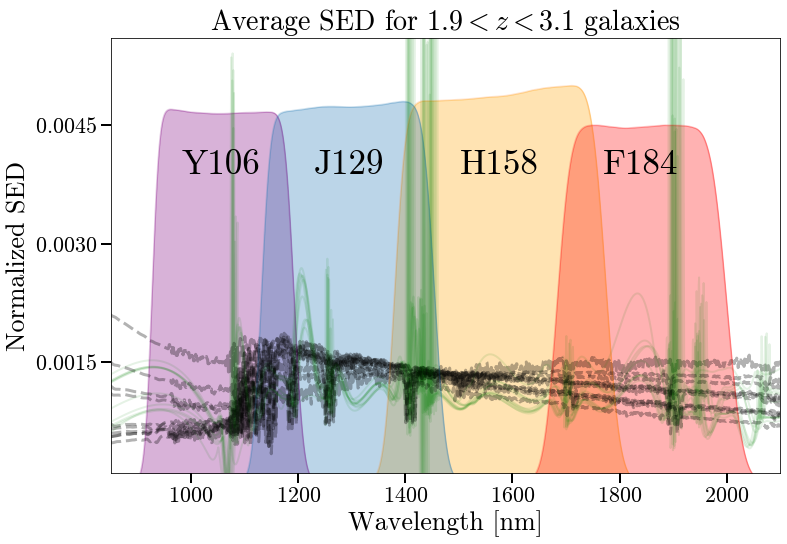

In [82]:
# cd2

fig, axs = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
zmin, zmax = 1.88, 1.92
z_mask = np.logical_and(z> zmin, z<zmax)
z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
for i in range(10):
    axs.plot(native_wave, avg_sed[z_mask][i], alpha = 0.1, color = 'green', lw = 2 )
    axs.plot(native_wave, avg_sed_cd2[z_mask_cd2][i], alpha = 0.3, color = 'black', lw = 3, ls = '--' )
#axs.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 1, ls = '--',lw = 3, color = 'black', label = 'cosmoDC2')
trans = roman_filters['H158'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.005, alpha = 0.2, ls = '-', color = 'C1')
axs.fill_between(native_wave, trans/np.max(trans)*0.005,  color='orange', alpha=0.3) 

trans = roman_filters['Y106'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0047, alpha = 0.2, ls = '-', color = 'purple')
axs.fill_between(native_wave, trans/np.max(trans)*0.0047,  color='purple', alpha=0.3)

trans = roman_filters['J129'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0048, alpha = 0.2, ls = '-', color = 'C0')
axs.fill_between(native_wave, trans/np.max(trans)*0.0048,  color='C0', alpha=0.3)

trans = roman_filters['F184'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0045, alpha = 0.2, ls = '-', color = 'red')
axs.fill_between(native_wave, trans/np.max(trans)*0.0045,  color='red', alpha=0.3)
axs.set_xlim(850,2100)
axs.set_ylim(0.0001,0.0056)
#axs.set_ylim(1e-28,1e-26)

axs.set_xlabel('Wavelength [nm]', fontsize = 26)
axs.set_ylabel('Normalized SED', fontsize = 26)
axs.tick_params('both', length=10, width=2,labelsize=22, which='major')


axs.legend(loc = 'upper right', frameon = False, fontsize = 23)

axs.text(1130, 0.0038, 'Y106', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1360, 0.0038, 'J129', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1650, 0.0038, 'H158', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1910, 0.0038, 'F184', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.yaxis.set_major_locator(plt.MaxNLocator(5))
axs.set_title(r'Average SED for $ 1.9 < z < 3.1$ galaxies', fontsize = 28)

plt.show()

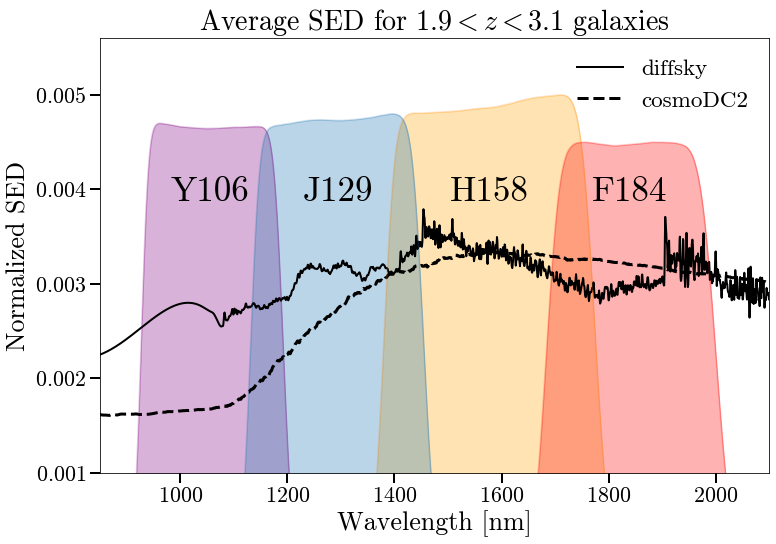

In [412]:
# cd2
fig, axs = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
zmin, zmax = 1.4, 1.9
z_mask = np.logical_and(z> zmin, z<zmax)
z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
#plt.plot(native_wave, np.mean(avg_sed, axis = 0), alpha = 0.5, color = 'black' )
#plt.plot(native_wave, np.mean(avg_sed_cd2, axis = 0), alpha = 0.5, color = 'black', ls = '--' )
#plt.plot(native_wave, np.mean(avg_sed[z_mask], axis = 0), alpha = 0.5, color = 'C0' )
#plt.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 0.5, ls = '--', color = 'C0')

zmin, zmax = 1.9, 3.1
z_mask = np.logical_and(z> zmin, z<zmax)
z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
axs.plot(native_wave, np.mean(avg_sed[z_mask], axis = 0), alpha = 1, color = 'black', lw = 2,label = 'diffsky' )
axs.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 1, ls = '--',lw = 3, color = 'black', label = 'cosmoDC2')
trans = bandpass(native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.005, alpha = 0.2, ls = '-', color = 'C1')
axs.fill_between(native_wave, trans/np.max(trans)*0.005,  color='orange', alpha=0.3) 

trans = roman_filters['Y106'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0047, alpha = 0.2, ls = '-', color = 'purple')
axs.fill_between(native_wave, trans/np.max(trans)*0.0047,  color='purple', alpha=0.3)

trans = roman_filters['J129'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0048, alpha = 0.2, ls = '-', color = 'C0')
axs.fill_between(native_wave, trans/np.max(trans)*0.0048,  color='C0', alpha=0.3)

trans = roman_filters['F184'](native_wave)
axs.plot(native_wave, trans/np.max(trans)*0.0045, alpha = 0.2, ls = '-', color = 'red')
axs.fill_between(native_wave, trans/np.max(trans)*0.0045,  color='red', alpha=0.3)
axs.set_xlim(850,2100)
axs.set_ylim(0.001,0.0056)

axs.set_xlabel('Wavelength [nm]', fontsize = 26)
axs.set_ylabel('Normalized SED', fontsize = 26)
axs.tick_params('both', length=10, width=2,labelsize=22, which='major')


axs.legend(loc = 'upper right', frameon = False, fontsize = 23)

axs.text(1130, 0.0038, 'Y106', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1360, 0.0038, 'J129', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1650, 0.0038, 'H158', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.text(1910, 0.0038, 'F184', fontsize=35, verticalalignment='bottom', horizontalalignment='right')
axs.yaxis.set_major_locator(plt.MaxNLocator(5))
axs.set_title(r'Average SED for $ 1.9 < z < 3.1$ galaxies', fontsize = 28)

plt.show()

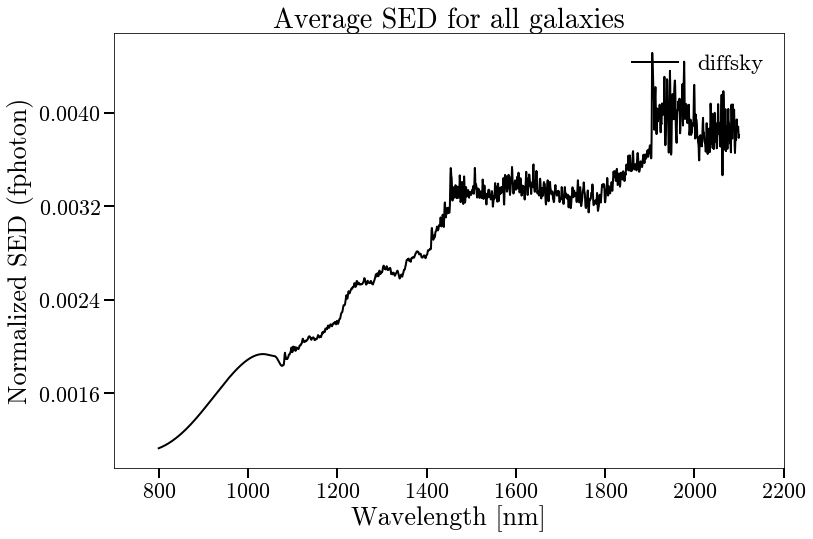

In [257]:
# cd2
fig, axs = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
#zmin, zmax = 1.4, 1.9
#z_mask = np.logical_and(z> zmin, z<zmax)
#z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
#plt.plot(native_wave, np.mean(avg_sed, axis = 0), alpha = 0.5, color = 'black' )
#plt.plot(native_wave, np.mean(avg_sed_cd2, axis = 0), alpha = 0.5, color = 'black', ls = '--' )
#plt.plot(native_wave, np.mean(avg_sed[z_mask], axis = 0), alpha = 0.5, color = 'C0' )
#plt.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 0.5, ls = '--', color = 'C0')

zmin, zmax = 1.9, 3
z_mask = np.logical_and(z> zmin, z<zmax)
#z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
axs.plot(native_wave, np.mean(avg_sed[z_mask], axis = 0), alpha = 1, color = 'black', lw = 2,label = 'diffsky' )
#axs.plot(native_wave, avg_sed[0], alpha = 1, color = 'black', lw = 2,label = 'diffsky' )
#axs.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 1, ls = '--',lw = 3, color = 'black', label = 'cosmoDC2')
trans = bandpass(native_wave)
axs.set_xlim(700,2200)
#axs.set_ylim(0.0001,0.00056)

axs.set_xlabel('Wavelength [nm]', fontsize = 26)
axs.set_ylabel('Normalized SED (fphoton)', fontsize = 26)
axs.tick_params('both', length=10, width=2,labelsize=22, which='major')


axs.legend(loc = 'upper right', frameon = False, fontsize = 23)

axs.yaxis.set_major_locator(plt.MaxNLocator(5))
axs.set_title(r'Average SED for all galaxies', fontsize = 28)

plt.show()

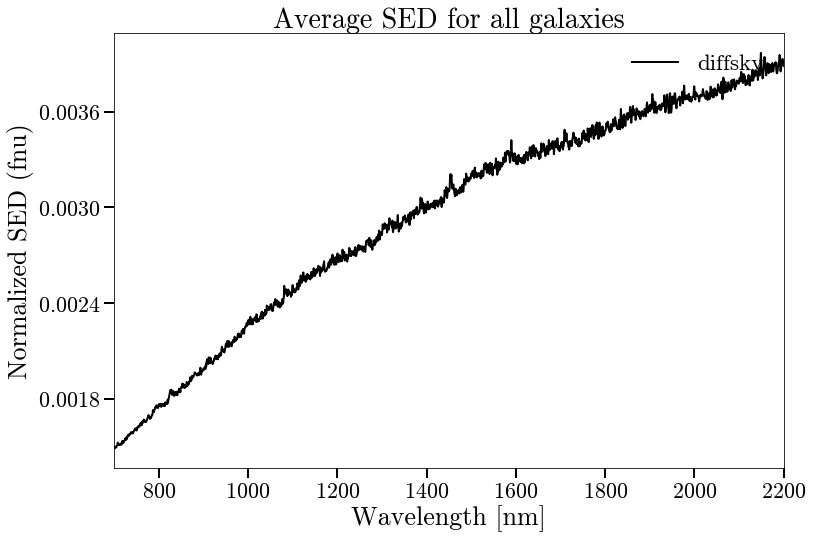

In [182]:
# cd2
fig, axs = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
#zmin, zmax = 1.4, 1.9
#z_mask = np.logical_and(z> zmin, z<zmax)
#z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
#plt.plot(native_wave, np.mean(avg_sed, axis = 0), alpha = 0.5, color = 'black' )
#plt.plot(native_wave, np.mean(avg_sed_cd2, axis = 0), alpha = 0.5, color = 'black', ls = '--' )
#plt.plot(native_wave, np.mean(avg_sed[z_mask], axis = 0), alpha = 0.5, color = 'C0' )
#plt.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 0.5, ls = '--', color = 'C0')

zmin, zmax = 0, 3
#z_mask = np.logical_and(z> zmin, z<zmax)
#z_mask_cd2 = np.logical_and(z_cd2> zmin, z_cd2<zmax)
axs.plot(native_wave, np.mean(avg_sed, axis = 0), alpha = 1, color = 'black', lw = 2,label = 'diffsky' )
#axs.plot(native_wave, avg_sed[0], alpha = 1, color = 'black', lw = 2,label = 'diffsky' )
#axs.plot(native_wave, np.mean(avg_sed_cd2[z_mask_cd2], axis = 0), alpha = 1, ls = '--',lw = 3, color = 'black', label = 'cosmoDC2')
trans = bandpass(native_wave)
axs.set_xlim(700,2200)
#axs.set_ylim(0.0001,0.00056)

axs.set_xlabel('Wavelength [nm]', fontsize = 26)
axs.set_ylabel('Normalized SED (fnu)', fontsize = 26)
axs.tick_params('both', length=10, width=2,labelsize=22, which='major')


axs.legend(loc = 'upper right', frameon = False, fontsize = 23)

axs.yaxis.set_major_locator(plt.MaxNLocator(5))
axs.set_title(r'Average SED for all galaxies', fontsize = 28)

plt.show()

In [232]:
flat_sed_fp = galsim.SED(lambda x:1, 'nm', 'fphotons').withFlux(1.,bandpass)
flat_sed_fp = galsim.SED(lambda x:x, 'nm', 'flambda').withFlux(1.,bandpass)
flat_sed_fl = galsim.SED(lambda x:1, 'nm', 'flambda').withFlux(1.,bandpass)
star = galsim.DeltaFunction()
psf = roman.getPSF(10, 'H158', n_waves = 10, pupil_bin= 8)
pixel_response = galsim.Pixel(roman.pixel_scale)
eff_psf = galsim.Convolve(psf, star)
star_fp = galsim.Convolve(psf, pixel_response*flat_sed_fp)
star_fl = galsim.Convolve(psf, pixel_response*flat_sed_fl)
star_fp = star_fp.drawImage(bandpass, scale=roman.pixel_scale/4,nx = 100,ny = 100, method = 'no_pixel')
star_fl = star_fl.drawImage(bandpass, scale=roman.pixel_scale/4,nx = 100,ny = 100, method = 'no_pixel')

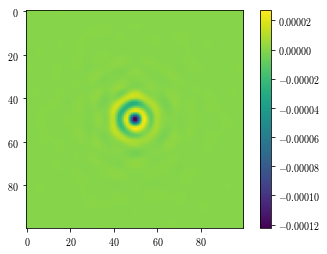

In [233]:

plt.imshow(star_fp.array/np.sum(star_fp.array) - star_fl.array/np.sum(star_fl.array))
plt.colorbar()
plt.show()


In [234]:
mom_fp = galsim.hsm.FindAdaptiveMom(star_fp, strict = False)
mom_fl = galsim.hsm.FindAdaptiveMom(star_fl, strict = False)
mom_fp.moments_sigma/mom_fl.moments_sigma - 1

0.0033371420591497003

In [276]:

avg_sed = np.zeros(2000)
z_num = 0
native_wave = np.linspace(1000, 2100, 2000)
for idx in range(600,601):
    cut = z_cd2[idx]> 0 and z_cd2[idx]<3
    if cut:
        filter_name = 'H158'
        if is_cosmoDC2:
            flux, sed_f = get_gal_obj_cd2(idx, filter_name)
        else:
            flux, sed_f = get_gal_obj(idx, filter_name)

        # Object SED calculation
        obj_wave = sed_f._orig_spec.x
        obj_f = sed_f._orig_spec.f
        obj_phot_sed = sed_f._flux_to_photons_fnu(obj_f, obj_wave)
        obj_wave = obj_wave * (1 + sed_f.redshift)
        obj_look = galsim.LookupTable(obj_wave, obj_phot_sed)
        obj_phot_sed = obj_look(native_wave)
        avg_sed += obj_phot_sed
        z_num += 1
avg_sed/= z_num

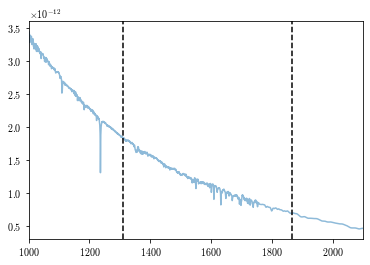

In [266]:
# cd2
plt.plot(native_wave, avg_sed, alpha = 0.5 )
plt.xlim(1000,2100)
#plt.ylim(0,2e-6)
plt.axvline(x = bandpass.blue_limit, color = 'black', ls = '--')
plt.axvline(x = bandpass.red_limit, color = 'black', ls = '--')
plt.show()

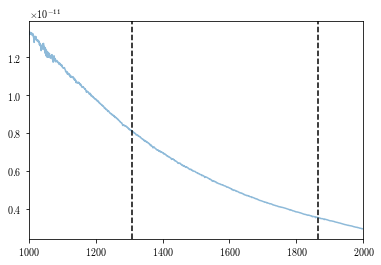

In [204]:
# cd2
plt.plot(native_wave, avg_sed, alpha = 0.5 )
plt.xlim(1000,2000)
#plt.ylim(0,2e-6)
plt.axvline(x = bandpass.blue_limit, color = 'black', ls = '--')
plt.axvline(x = bandpass.red_limit, color = 'black', ls = '--')
plt.show()

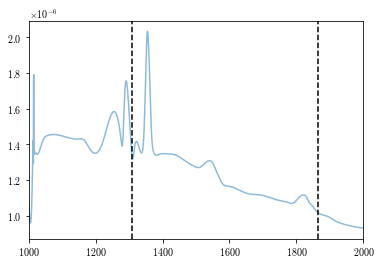

In [277]:
plt.plot(native_wave, avg_sed, alpha = 0.5 )
plt.xlim(1000,2000)
#plt.ylim(0,2e-6)
plt.axvline(x = bandpass.blue_limit, color = 'black', ls = '--')
plt.axvline(x = bandpass.red_limit, color = 'black', ls = '--')
plt.show()

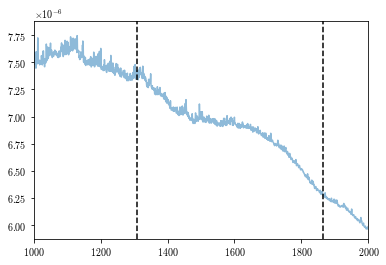

In [179]:
plt.plot(native_wave, avg_sed, alpha = 0.5 )
plt.xlim(1000,2000)
#plt.ylim(0,2e-6)
plt.axvline(x = bandpass.blue_limit, color = 'black', ls = '--')
plt.axvline(x = bandpass.red_limit, color = 'black', ls = '--')
plt.show()

In [152]:
np.mean(an_slope_diffsky['H158']['F184']), np.mean(coeff_gal['H158'])

(-4.067444421037212e-07, -8.339746814698567e-07)

In [151]:
np.mean(an_slope_cd2['H158']['J129']), np.mean(coeff_gal_cd2['H158'])

(-1.1002491746552572e-06, -1.0516454609902077e-06)

In [126]:
raw_flux['H158'][id_], sed_f.calculateFlux(bandpass)

(9.815286350015978e-07, 0.00029075649217702465)

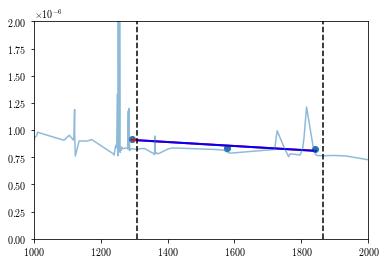

In [137]:
id_ = idx
bandpass = roman_filters['H158']
bp_0 = bandpass.effective_wavelength
norm_h = effective_wavelength(roman_filters['H158'], order = 0, norm = False, cent = 0)
l_test =eff_wave[1:4] 
f_test = [raw_flux['J129'][id_], raw_flux['H158'][id_], raw_flux['F184'][id_]]

degree = 1 # You can change this degree based on how complex you want the fit to be
coeffs = np.polyfit(l_test, f_test, degree)

# Generate smooth x values for plotting the best-fit curve
x_smooth = np.linspace(min(l_test), max(l_test), 300)  # 300 points for smooth curve
y_smooth = np.polyval(coeffs, x_smooth)  # Evaluate the polynomial at these x values

obj_mask = (x_smooth >= bandpass.blue_limit) & (x_smooth <= bandpass.red_limit)
w = bandpass(x_smooth[obj_mask])
coeffs_fit = np.polyfit(x_smooth[obj_mask], y_smooth[obj_mask], 1, w = w)
y_fit = np.polyval(coeffs_fit, x_smooth[obj_mask])
# Plot the best-fit curve
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label=f'Best Fit Polynomial (deg={degree})')
plt.plot(x_smooth[obj_mask], y_fit, color='blue', linewidth=2, label=f'Best Fit Polynomial (deg={1}')

plt.scatter(l_test, f_test)
plt.plot(obj_wave, obj_phot_sed, alpha = 0.5 )
plt.xlim(1000,2000)
plt.ylim(0,2e-6)
plt.axvline(x = bandpass.blue_limit, color = 'black', ls = '--')
plt.axvline(x = bandpass.red_limit, color = 'black', ls = '--')
plt.show()

In [138]:
coeffs[0]/norm_h/raw_flux['H158'][id_],coeff_gal['H158'][id_]

(-7.173330067885316e-07, 5.164730986247581e-07)

In [104]:
def compute_slope(x, y):
    n = len(x)  # Number of points
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_x2 = np.sum(x ** 2)

    # Compute slope using the least squares formula
    m = (sum_xy - (sum_x * sum_y) / n) / (sum_x2 - (sum_x ** 2) / n)
    
    return m

In [105]:
l_test =eff_wave[1:4]
an_3pt_slope = []
norm_h = effective_wavelength(roman_filters['H158'], order = 0, norm = False, cent = 0)
for i in range(10000):
    f_test = [raw_flux['J129'][i], raw_flux['H158'][i], raw_flux['F184'][i]]
    s = compute_slope(l_test, f_test)/norm_h/raw_flux['H158'][i]
    an_3pt_slope.append(s)
an_3pt_slope = np.array(an_3pt_slope)

In [86]:
l_test =eff_wave[1:4]
#an_3pt_slope = []
norm_h = effective_wavelength(roman_filters['H158'], order = 0, norm = False, cent = 0)
avg_f = np.zeros(3)
num_z = 0
for i in range(10000):
    if z[i] > 0:
        avg_f += np.array([raw_flux['J129'][i], raw_flux['H158'][i], raw_flux['F184'][i]])/raw_flux['H158'][i]
        num_z += 1
avg_f /= num_z
s = compute_slope(l_test, avg_f)/norm_h
#an_3pt_slope = np.array(an_3pt_slope)

In [106]:
#z_cut = np.logical_and(z > 1.4, z < 1.9)
z_cut = np.logical_and(z > 1.9, z < 3.1)
#z_cut = np.logical_and(z > 1, z < 1.4)
np.mean(an_3pt_slope[z_cut]), np.mean(an_slope_diffsky['H158']['F184'][z_cut]), np.mean(coeff_gal['H158'][z_cut])

(4.636842083335768e-07, 2.4349733857488826e-07, -1.1043259952424766e-06)

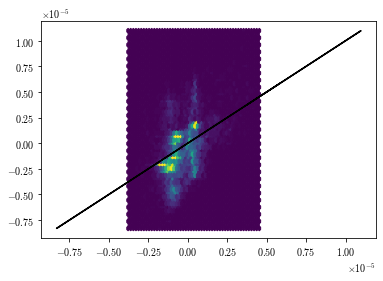

In [107]:
plt.hexbin(an_3pt_slope,coeff_gal['H158'] ,gridsize=50,vmin=0, vmax=100)
plt.plot( coeff_gal['H158'], coeff_gal['H158'], color = 'black')
plt.show()

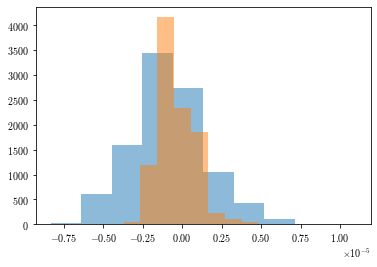

In [196]:
plt.hist(coeff_gal['H158'], alpha = 0.5)
plt.hist(an_3pt_slope, alpha = 0.5)
plt.show()

In [195]:
np.mean(an_3pt_slope[z>1.9]), np.mean(coeff_gal['H158'][z>1.9]), s

(7.096655459993926e-07, -1.1043259952424766e-06, 7.096655459993927e-07)

In [183]:
z_cut = np.logical_and(z > 1.4, z < 1.9)
#z_cut = np.logical_and(z > 1.9, z < 3.1)
#z_cut = np.logical_and(z > 1, z < 1.4)
np.mean(an_3pt_slope[z_cut]), -np.mean(an_slope_diffsky['H158']['F184'][z_cut]), np.mean(coeff_gal['H158'][z_cut])

(-4.644051831874717e-07, 8.282545523771109e-08, 7.376563130205197e-07)

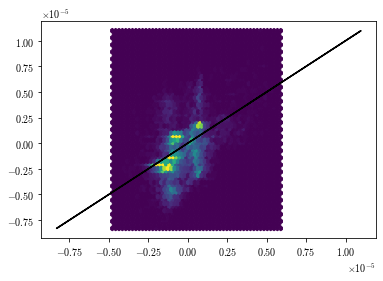

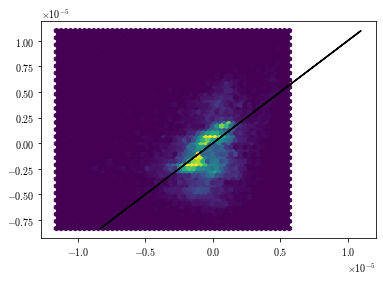

In [170]:
#plt.scatter(an_3pt_slope,coeff_gal['H158'] )
plt.hexbin(an_3pt_slope,coeff_gal['H158'] ,gridsize=50,vmin=0, vmax=100)
plt.plot( coeff_gal['H158'], coeff_gal['H158'], color = 'black')
plt.show()

plt.hexbin(an_slope_diffsky['H158']['F184'],coeff_gal['H158'] ,gridsize=50,vmin=0, vmax=100)
plt.plot( coeff_gal['H158'], coeff_gal['H158'], color = 'black')
plt.show()

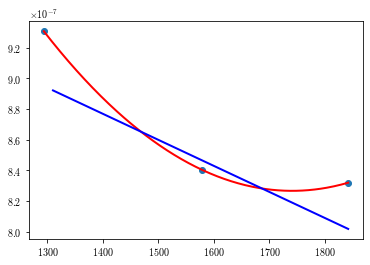

In [160]:
id_ = 100
bandpass = roman_filters['H158']
bp_0 = bandpass.effective_wavelength
norm_h = effective_wavelength(roman_filters['H158'], order = 0, norm = False, cent = 0)
l_test =eff_wave[1:4] 
f_test = [raw_flux['J129'][id_], raw_flux['H158'][id_], raw_flux['F184'][id_]]

degree = 2 # You can change this degree based on how complex you want the fit to be
coeffs = np.polyfit(l_test, f_test, degree)

# Generate smooth x values for plotting the best-fit curve
x_smooth = np.linspace(min(l_test), max(l_test), 300)  # 300 points for smooth curve
y_smooth = np.polyval(coeffs, x_smooth)  # Evaluate the polynomial at these x values

obj_mask = (x_smooth >= bandpass.blue_limit) & (x_smooth <= bandpass.red_limit)
w = bandpass(x_smooth[obj_mask])
coeffs_fit = np.polyfit(x_smooth[obj_mask], y_smooth[obj_mask], 1, w = w)
y_fit = np.polyval(coeffs_fit, x_smooth[obj_mask])
# Plot the best-fit curve
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label=f'Best Fit Polynomial (deg={degree})')
plt.plot(x_smooth[obj_mask], y_fit, color='blue', linewidth=2, label=f'Best Fit Polynomial (deg={1}')

plt.scatter(l_test, f_test)
plt.show()
#print(z[id_])

In [162]:
guess = 2*coeffs[0]*bp_0 + coeffs[1]
guess/norm_h/raw_flux['H158'][id_],coeff_gal['H158'][id_]

(-6.525962623735518e-07, 5.164730986247581e-07)

In [121]:
coeffs_fit[0], raw_flux['H158'][id_], coeffs

(-1.4918108427611258e-10,
 4.854491778489938e-07,
 array([-5.83101762e-13,  1.69060057e-09, -7.30179810e-07]))

In [159]:
coeffs[0]/norm_h/raw_flux['H158'][id_],coeff_gal['H158'][id_]

(-2.896308141417966e-07, -1.0022440016027609e-06)

In [68]:
z_cut = np.logical_and(z > 1.4, z < 1.9)
np.mean((an_diff_F)[z_cut]), np.mean((an_diff_J)[z_cut]) , np.mean(coeff_diff['H158'][z_cut]) 

(-3.272229522557936e-06, -2.542839147481644e-06, -3.9254854144087186e-06)

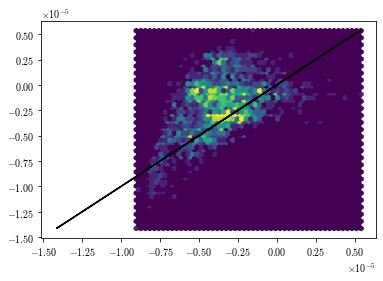

In [48]:
#plt.hexbin(an_diff_J, an_diff_F,gridsize=50,vmin=0, vmax=100)
plt.hexbin((an_diff_F)[z > 1.9],coeff_diff['H158'][z > 1.9],gridsize=50,vmin=0, vmax=10)
#plt.hexbin(an_diff_F,coeff_diff['H158'],gridsize=50,vmin=0, vmax=30)
plt.plot( coeff_diff['H158'][z > 1.9], coeff_diff['H158'][z > 1.9], color = 'black')
plt.show()

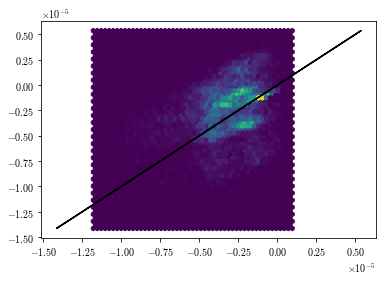

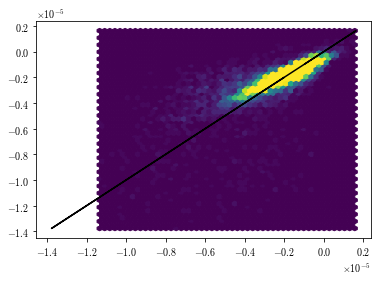

In [29]:
plt.hexbin(an_diff_J, coeff_diff['H158'] ,gridsize=50,vmin=0, vmax=100)
plt.plot( coeff_diff['H158'], coeff_diff['H158'], color = 'black')
plt.show()

plt.hexbin(an_diff_cd2_J, coeff_diff_cd2['H158'] ,gridsize=50,vmin=0, vmax=50)
plt.plot( coeff_diff_cd2['H158'], coeff_diff_cd2['H158'], color = 'black')
plt.show()

In [13]:
def get_best_est(an_slope_star, an_slope_gal, coeff_diff):
    best_diff = {}
    best_diff_filters = {}
    for ref in use_filters:
        y_true = coeff_diff[ref] 
        filts = use_filters[use_filters != ref]
        diff = np.inf
        for filt_ in filts:
            an_diff = an_slope_star[ref][filt_] - an_slope_gal[ref][filt_]
            temp_diff = np.sum((an_diff - y_true)**2)
            if temp_diff < diff:
                best_diff[ref] = an_diff
                best_diff_filters[ref] = filt_
                diff = temp_diff
    return best_diff, best_diff_filters

In [240]:
best_diff, best_diff_filts = get_best_est(an_slope_star, an_slope_diffsky, coeff_diff)
best_diff_cd2, best_diff_filts_cd2 = get_best_est(an_slope_star, an_slope_cd2, coeff_diff_cd2)

In [242]:
best_diff_filts, best_diff_filts_cd2

({'Y106': 'F184', 'J129': 'H158', 'H158': 'F184', 'F184': 'J129'},
 {'Y106': 'F184', 'J129': 'H158', 'H158': 'J129', 'F184': 'J129'})

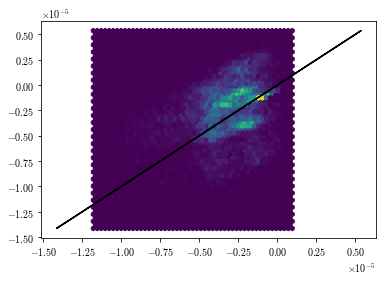

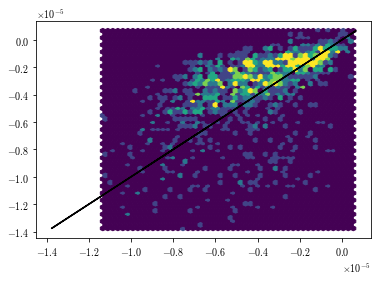

In [233]:
#plt.scatter(an_diff, coeff_diff['H158'])
plt.hexbin(an_diff, coeff_diff['H158'] ,gridsize=50,vmin=0, vmax=100)
plt.plot( coeff_diff['H158'], coeff_diff['H158'], color = 'black')
plt.show()

plt.hexbin(an_diff_cd2[z_cd2 > 1.9], coeff_diff_cd2['H158'][z_cd2 > 1.9] ,gridsize=50,vmin=0, vmax=5)
plt.plot( coeff_diff_cd2['H158'][z_cd2 > 1.9], coeff_diff_cd2['H158'][z_cd2 > 1.9], color = 'black')
plt.show()

In [220]:
np.mean(an_diff_cd2[z_cd2 > 1.9]), np.mean(coeff_diff_cd2['H158'][z_cd2 > 1.9])

(-4.143127476662723e-06, -3.5810549393150438e-06)

In [15]:
ref = 'H158' 
s1 = anal_slope(obs_mags, filt_ = 'Y106', ref = ref)
s2 = anal_slope(obs_mags, filt_ = 'J129', ref = ref)
s3 = anal_slope(obs_mags, filt_ = 'F184', ref = ref)

s1_cd2 = anal_slope(obs_mags_cd2, filt_ = 'Y106', ref = ref)
s2_cd2 = anal_slope(obs_mags_cd2, filt_ = 'J129', ref = ref)
s3_cd2 = anal_slope(obs_mags_cd2, filt_ = 'F184', ref = ref)


s1_star = anal_slope(obs_star_mags, filt_ = 'Y106', ref = ref)
s2_star= anal_slope(obs_star_mags, filt_ = 'J129', ref = ref)
s3_star = anal_slope(obs_star_mags, filt_ = 'F184', ref = ref)

y = coeff_gal[ref]
y_star = coeff_star[ref]
y_cd2 = coeff_gal_cd2[ref]
#y_star = coeff_star_slope_train['A'][ref]

In [130]:
star_slopes = s1_star[:40]
star_f = flux_star[ref][:40]
star_cut = np.logical_and(snr_stars[ref][:40] > 100, true_star_mags[ref][:40] > 17.9)
np.sum(star_slopes[star_cut]*star_f[star_cut])/np.sum(star_f[star_cut])

-4.021130562694179e-06

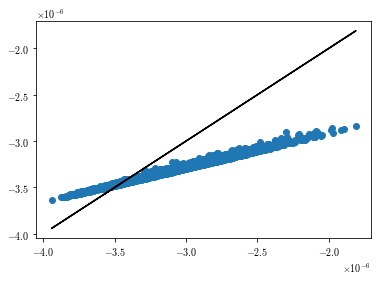

In [201]:
plt.scatter(y_star, an_slope_star['H158']['F184'])
plt.plot(y_star, y_star, color = 'black')
plt.show()

In [158]:
y_star_an = []
zp = roman_filters[ref].zeropoint
star_fluxes = 10**(-(obs_star_mags[ref] - zp)/2.5)
for i in range(len(y_star) ):
    star_slopes = s2_star[i*40:(i+1)*40]
    star_f = star_fluxes[i*40:(i+1)*40]
    star_cut = np.logical_and(snr_stars[ref][i*40:(i+1)*40] > 100, true_star_mags[ref][i*40:(i+1)*40] > 17.9)
    pred = np.sum(star_slopes[star_cut]*star_f[star_cut])/np.sum(star_f[star_cut])
    y_star_an.append(pred)
np.mean(y_star_an)

-3.3563501152740433e-06

In [119]:
np.mean(s1_star), np.mean(s2_star), np.mean(s3_star), np.mean(coeff_star[ref])

(-3.3679633273340493e-06,
 -2.9234284924468885e-06,
 -3.2385903418678837e-06,
 -3.192845829110543e-06)

In [120]:
np.mean((s1_star + s2_star + s3_star)/3 )

-3.176660720549607e-06

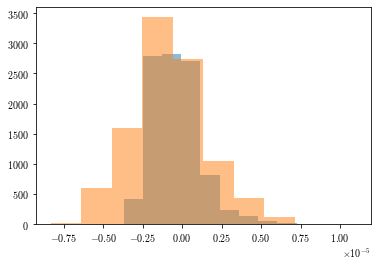

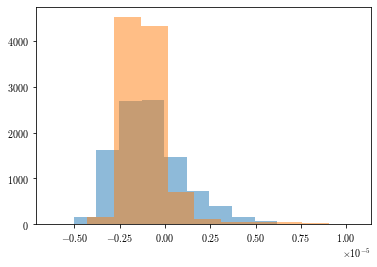

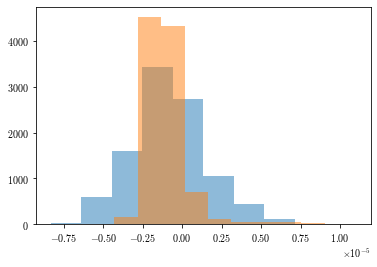

In [114]:
#plt.hist(s1, alpha = 0.5)
#plt.hist(s2, alpha = 0.5)
#plt.hist(s3, alpha = 0.5)
plt.hist((s2), alpha = 0.5)
plt.hist(y, alpha = 0.5)
plt.show()

plt.hist((s1_cd2 ), alpha = 0.5)
plt.hist(y_cd2, alpha = 0.5)
plt.show()

plt.hist(y, alpha = 0.5)
plt.hist(y_cd2, alpha = 0.5)
plt.show()



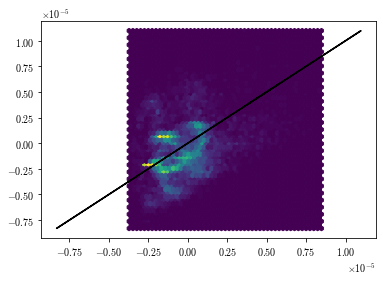

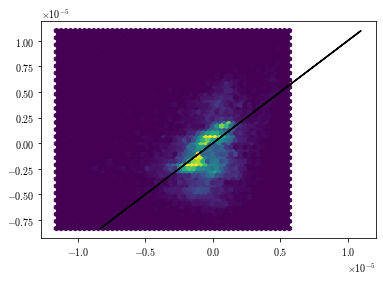

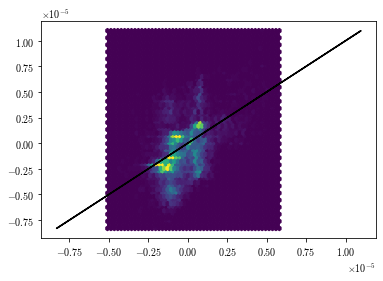

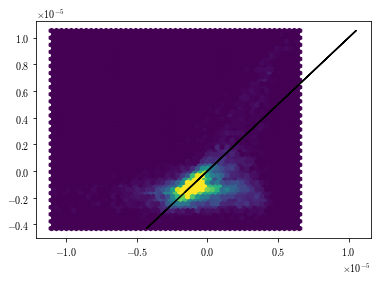

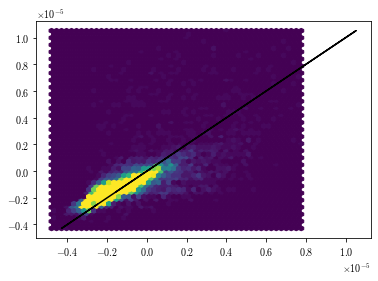

In [99]:
plt.hexbin(s2, y ,gridsize=50,vmin=0, vmax=100)
plt.plot(y, y, color = 'black')
plt.show()

plt.hexbin(s3, y ,gridsize=50,vmin=0, vmax=100)
plt.plot(y, y, color = 'black')
plt.show()

plt.hexbin((s3 + s2)/2, y ,gridsize=50,vmin=0, vmax=100)
plt.plot(y, y, color = 'black')
plt.show()

#plt.scatter(s3_cd2, y_cd2)
plt.hexbin(s3_cd2, y_cd2 ,gridsize=50,vmin=0, vmax=100)
plt.plot(y_cd2, y_cd2, color = 'black')
plt.show()

#plt.scatter(s2_cd2, y_cd2)
plt.hexbin(s2_cd2, y_cd2 ,gridsize=50,vmin=0, vmax=50)
plt.plot(y_cd2, y_cd2, color = 'black')
plt.show()

In [57]:
obs_mags['H158'], obs_mags['J129']

(array([23.87700239, 22.04535703, 24.24638561, ..., 23.01775092,
        24.43577331, 24.73003302]),
 array([24.10066864, 22.30444197, 24.3191894 , ..., 23.12872215,
        24.61526863, 25.00148213]))

In [74]:
pickle_out = open("Gal_props_catnoise/roman_gal_obsmags_diffsky_10307_10000cut","rb")
roman_mag_info = pickle.load(pickle_out)
pickle_out.close()
diff_h = roman_mag_info['true_mag']['A']['H158'] #- obs_mags['H158']
diff_j = roman_mag_info['true_mag']['A']['F184'] #- obs_mags['F184']

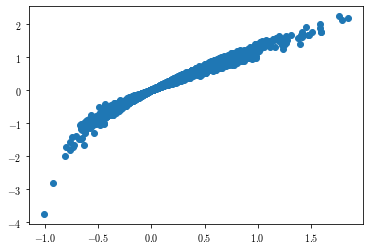

In [64]:
plt.scatter(diff_h, diff_j)
plt.show()

## Accuracy

In [26]:
from sklearn.metrics import r2_score

In [ ]:
## diffsky

In [823]:
pickle_in = open("SED_fit_coeff/final_run/10000Gal_pred_A_H_diffsky_10307" ,"rb")
pred_coeff = pickle.load(pickle_in)
pickle_in.close()

In [824]:
pickle_in = open("SED_fit_coeff/final_run/10000Gal_SOMpred_A_H_diffsky_10307" ,"rb")
pred_coeff_SOM = pickle.load(pickle_in)
pickle_in.close()

In [825]:
scenarios = ['A']
use_filters = [ 'H158']
coeff_diff_slope = {}
#for scenario  in scenarios:
pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_diffsky_10307", "rb")
#pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_cosmoDC2_10067", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff_slope = {}
coeff_gal = {}
coeff_star = {}
flux_star = {}
flux_gal = {}
coeff_diff_0th = {}
coeff_diff_2nd = {}
coeff_diff_3rd = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff_slope[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal[filter_] = coeffs['gal'][1][filter_]
    coeff_star[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]
    coeff_diff_0th[filter_] = coeffs['star:'][0][filter_]- coeffs['gal'][0][filter_]
    coeff_diff_2nd[filter_] = coeffs['star:'][2][filter_]*coeffs['gal'][0][filter_] - coeffs['star:'][0][filter_]*coeffs['gal'][2][filter_]
    coeff_diff_2nd[filter_] = coeff_diff_2nd[filter_]
coeff_diff = coeff_diff_slope.copy()

In [826]:

def est_acc (y_pred, y_true):
    #frac_diff = abs(np.median(((y_pred)/(y_true) - 1)))
    #frac_diff = (np.median(abs((y_pred)/(y_true) - 1)))
    #frac_diff = np.median((y_pred/y_true - 1))
    #frac_diff = np.average((y_pred/y_true - 1), weights = y_true)
    #frac_diff = np.sum((y_pred - y_true)**2)
    #frac_diff = (np.median((y_pred-y_true)))/np.median(y_true)
    #frac_diff = np.median(y_pred)/np.median(y_true) - 1
    frac_diff = np.mean((y_pred)-(y_true))/np.mean(y_true)
    #frac_diff = (np.median(y_pred/np.mean(y_true)*(y_pred/y_true - 1)))
    #frac_diff = np.median(y_pred)/np.median(y_true) - 1
    #std_err = 1.2533*np.std((y_pred-y_true))/np.sqrt(len(y_true))/np.median(y_true)
    std_err = frac_diff_se(y_pred, y_true)
    #norm = np.std(y_true)/abs(np.mean((y_true)))
    #frac_diff /= norm
    return frac_diff, std_err

def frac_diff_se(y_pred, y_true):
    n = len(y_true)
    
    # Compute medians
    M_delta = np.median(y_pred - y_true)
    M_T = np.median(y_true)
    
    # Compute MAD for each term
    mad_delta = np.std(y_pred - y_true)
    mad_T =  np.std(y_true)
    
    # Compute standard errors of the medians
    sigma_M_delta = 1.253 * mad_delta / np.sqrt(n)
    sigma_M_T = 1.253 * mad_T / np.sqrt(n)
    
    # Propagate error using the formula
    sigma_frac_diff = np.sqrt((sigma_M_delta / M_T) ** 2 + (M_delta * sigma_M_T / M_T ** 2) ** 2)

    return sigma_frac_diff

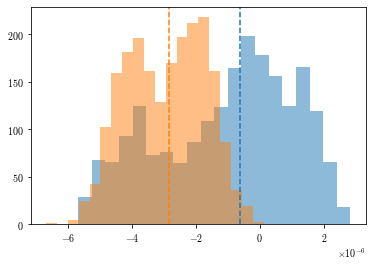

(-2.8295125422532257e-06, -6.143294117457226e-07, 1)

In [656]:
mask = np.logical_and(z > 1, z < 1.4)
plt.hist(coeff_diff['H158'][mask], alpha = 0.5, bins = 20)
plt.hist( pred_coeff['J'][mask], alpha = 0.5, bins = 20)
plt.axvline(x = np.median(coeff_diff['H158'][mask]), color = 'C0', ls = '--')
plt.axvline(x = np.median(pred_coeff['J'][mask]), color = 'C1', ls = '--')
plt.show()
np.median(pred_coeff['J'][mask]), np.median(coeff_diff['H158'][mask]), 1

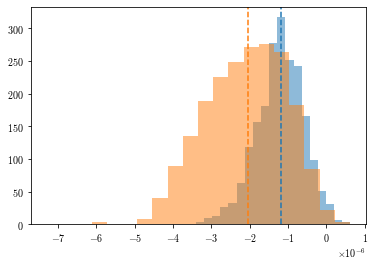

0.7388482393552058

In [654]:
mask = np.logical_and(z > 0, z < 0.65)
plt.hist(coeff_diff['H158'][mask], alpha = 0.5, bins = 20)
plt.hist( pred_coeff['J'][mask], alpha = 0.5, bins = 20)
plt.axvline(x = np.median(coeff_diff['H158'][mask]), color = 'C0', ls = '--')
plt.axvline(x = np.median(pred_coeff['J'][mask]), color = 'C1', ls = '--')
plt.show()
np.mean(pred_coeff['J'][mask])/np.mean(coeff_diff['H158'][mask]) - 1

In [827]:
# accuracy for J-H
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff['J'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z > z_bins[j], z < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(0.6050913157762542, 0.023962009077811333)
(-0.2184918861684694, 0.008998842143255895)
(1.7112803875633364, 0.35706046085498405)
(-0.3932187431044173, 0.022515217103984055)
(1.065024159371973, 0.06388344712981633)
(0.19965109530432565, 0.01536376052514832)


In [828]:
# accuracy for F-H
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff['F'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z > z_bins[j], z < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(0.4173430990874252, 0.025007074863635136)
(-0.22800685884080665, 0.0071509767111463274)
(1.8756742246635392, 0.3190868588433247)
(-0.20901409167044802, 0.02350429588471644)
(0.6433566483091547, 0.0433710956951199)
(0.18111639535438215, 0.01368908044627464)


In [684]:
# accuracy for SOM
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff_SOM['H158'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z > z_bins[j], z < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(0.3346736506254119, 0.024184527977311417)
(-0.02927657594806791, 0.00638973681949879)
(1.1676986164300165, 0.1302533913423031)
(-0.25107480498908125, 0.020855122010236305)
(0.20890764430533415, 0.03848555625366742)
(0.08672428194531263, 0.01247930997979304)


In [603]:
mask = np.logical_and(z > 1.9, z < 3.1)
np.mean(pred_coeff['J'][mask]), np.mean( y_true[mask]), np.std( y_true[mask])/np.mean( y_true[mask])

(-4.492142658121765e-06, -2.094986252741248e-06, -1.2435702379397011)

In [546]:
## cosmodc2

In [817]:
pickle_in = open("SED_fit_coeff/final_run/10000Gal_pred_A_H_cosmoDC2_10067" ,"rb")
pred_coeff = pickle.load(pickle_in)
pickle_in.close()

In [818]:
pickle_in = open("SED_fit_coeff/final_run/10000Gal_SOMpred_A_H_cosmodc2_10067" ,"rb")
pred_coeff_SOM = pickle.load(pickle_in)
pickle_in.close()

In [819]:
scenarios = ['A']
use_filters = [ 'H158']
coeff_diff_slope = {}
#for scenario  in scenarios:
#pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_diffsky_10307", "rb")
pickle_in = open("SED_fit_coeff/final_run/10000Gal_1ordfit_A_YJHFW_cosmoDC2_10067", "rb")
coeffs = pickle.load(pickle_in)
pickle_in.close()
coeff_diff_slope = {}
coeff_gal = {}
coeff_star = {}
flux_star = {}
flux_gal = {}
coeff_diff_0th = {}
coeff_diff_2nd = {}
coeff_diff_3rd = {}
for filter_ in use_filters:
    coeffs_gal_slope = coeffs['gal'][1][filter_]
    coeffs_star_slope = coeffs['star:'][1][filter_]
    coeff_diff_slope[filter_] = coeffs_star_slope - coeffs_gal_slope
    coeff_gal[filter_] = coeffs['gal'][1][filter_]
    coeff_star[filter_] = coeffs['star:'][1][filter_]
    flux_star[filter_] = coeffs['star_fluxes'][filter_]
    flux_gal[filter_] = coeffs['gal_fluxes'][filter_]
    coeff_diff_0th[filter_] = coeffs['star:'][0][filter_]- coeffs['gal'][0][filter_]
    coeff_diff_2nd[filter_] = coeffs['star:'][2][filter_]*coeffs['gal'][0][filter_] - coeffs['star:'][0][filter_]*coeffs['gal'][2][filter_]
    coeff_diff_2nd[filter_] = coeff_diff_2nd[filter_]
coeff_diff = coeff_diff_slope.copy()

In [821]:
# accuracy for J-H
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff['J'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z_cd2 > z_bins[j], z_cd2 < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(-0.053996669216850576, 0.01119282679227237)
(0.0007483404699803733, 0.007884816965957013)
(-0.09757709905406808, 0.007277333877506186)
(-0.0723921312244565, 0.009038057825822393)
(0.11045352206549444, 0.03150296231764408)
(-0.02269928325657651, 0.006883642398630507)


In [822]:
# accuracy for F-H
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff['F'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z_cd2 > z_bins[j], z_cd2 < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(0.49652542872317984, 0.04067115083318368)
(0.2594010757968507, 0.02326172115066425)
(0.20895443509166844, 0.0177992773938971)
(0.3082405112110815, 0.021056727556912364)
(0.1577933307336373, 0.028070474841228366)
(0.2643388710127005, 0.011522638062486046)


In [820]:
# accuracy for SOM
z_bins = [0.0, 0.65, 1.0, 1.4, 1.9, 3.5]
y_pred, y_true = pred_coeff_SOM['H158'], coeff_diff['H158']
for j in range(0,5):
    mask = np.logical_and(z_cd2 > z_bins[j], z_cd2 < z_bins[j + 1])
    print(est_acc (y_pred[mask], y_true[mask]))
print(est_acc (y_pred, y_true))

(0.4182753483300203, 0.024215840112590717)
(0.21258385637056812, 0.010797821714735414)
(0.12493054478638883, 0.009329248558434516)
(0.1748276714493983, 0.015212401010120101)
(-0.02359782343325966, 0.03271476252869086)
(0.15837451465851712, 0.008512733239481714)


In [519]:
mask = np.logical_and(z_cd2 > 0, z_cd2 < 0.65)
np.mean(pred_coeff['F'][mask])/np.mean( y_true[mask])

1.6230524970881026

In [224]:
0.001/(0.0025)

0.4

In [48]:
1- np.median(abs(pred_coeff['H158']/coeff_diff['H158'] - 1))

0.7557991680484258

In [62]:
z_cut = np.logical_and(z_cd2 > 1.9, z_cd2 < 3.1)
1- np.median(abs((pred_coeff['F'][z_cut])/(coeff_diff['H158'][z_cut]) - 1))

0.6602588310970405

In [38]:
z_cut = np.logical_and(z_cd2 > 1, z_cd2 < 1.4)
np.mean((pred_coeff['F'][z_cut])), np.mean((pred_coeff['J'][z_cut])), np.mean((coeff_diff['H158'][z_cut]))

(-2.84282792916143e-06, -2.1609960415988515e-06, -2.2144388867478595e-06)

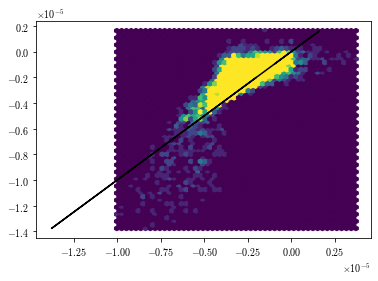

In [34]:
plt.hexbin(pred_coeff['JF'], coeff_diff['H158'] ,gridsize=50,vmin=0, vmax=10)
plt.plot(coeff_diff['H158'], coeff_diff['H158'], color = 'black')
plt.show()